# Notebook 04 - Simple Pipeline

### Import requirements

In [1]:
# natural language processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# machine learning
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import itertools
from collections import Counter
import numpy as np
import pandas as pd
pd.set_option('chained_assignment',None)
import matplotlib.pyplot as plt
% matplotlib inline

### Read in data

In [2]:
df_train_block = pd.read_csv("../processed_data/train_blocks.csv")
df_test_block = pd.read_csv("../processed_data/test_blocks.csv")

print(df_train_block.shape)
print(df_test_block.shape)

(578, 3)
(336, 3)


### Helper functions

In [3]:
def standardize_text(dataframe, text_field):
    """
    Standardizes text fields by replacing characters.
    Parameters:
        dataframe: a dataframe containing a column with text
        text_field: the column to standardize
    Returns:
        dataframe: the same dataframe corrected
    """
    dataframe[text_field] = dataframe[text_field].str.replace(r"http\S+", "")
    dataframe[text_field] = dataframe[text_field].str.replace(r"http", "")
    dataframe[text_field] = dataframe[text_field].str.replace(r"@\S+", "")
    dataframe[text_field] = dataframe[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    dataframe[text_field] = dataframe[text_field].str.replace(r"@", "at")
    dataframe[text_field] = dataframe[text_field].str.lower()
    return dataframe

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Text preprocessing and target selection

In [4]:
# clean up text
df_train_block_clean = standardize_text(df_train_block, "Text Block")
df_test_block_clean = standardize_text(df_test_block, "Text Block")

# select data fields
X_train, X_test = df_train_block_clean['Text Block'], df_test_block_clean['Text Block']
y_train, y_test = df_train_block_clean['Author'], df_test_block_clean['Author']

### Bag of Words and TF-IDF vectorization

In [5]:
# intialize vectorizers
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# fit and transform the data

# bag of words
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
print("Bag of Words:", X_train_bow.shape, X_test_bow.shape)

# tf-idf
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print("TF-IDF:", X_train_tfidf.shape, X_test_tfidf.shape)

Bag of Words: (578, 7324) (336, 7324)
TF-IDF: (578, 7324) (336, 7324)


In [21]:
type(bow_vectorizer)

sklearn.feature_extraction.text.CountVectorizer

In [20]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [22]:
type(X_test_bow)

scipy.sparse.csr.csr_matrix

### Cross validation parameter search

In [6]:
# Create hyperparamter space
hyperparameters = dict(C = np.logspace(-4, 0, num=100), penalty = ['l1','l2'])

# Create grid search using 5-fold cross validation
lr = LogisticRegression(solver='saga',multi_class='auto',class_weight='balanced',max_iter=1000)
lr_clf = GridSearchCV(lr, hyperparameters, cv=5, verbose=1, n_jobs=-1)
best_lr_model_bow = lr_clf.fit(X_train_bow, y_train)

# View best hyperparameters
print('Best Solver:', best_lr_model_bow.best_estimator_.get_params()['solver'])
print('Best Penalty:', best_lr_model_bow.best_estimator_.get_params()['penalty'])
print('Best C:', best_lr_model_bow.best_estimator_.get_params()['C'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 505 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 855 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.1min finished


Best Solver: saga
Best Penalty: l2
Best C: 0.10722672220103242


### Cross validation performance

In [7]:
best = lr_clf.best_index_
df_cv_lr = pd.DataFrame(lr_clf.cv_results_).iloc[best,:]
test_scores = ["split0_test_score", "split1_test_score", "split2_test_score",
               "split3_test_score","split4_test_score", "mean_test_score"]

display(df_cv_lr[test_scores])

split0_test_score    0.854701
split1_test_score    0.810345
split2_test_score    0.791304
split3_test_score    0.834783
split4_test_score    0.869565
mean_test_score       0.83218
Name: 151, dtype: object

In [8]:
lr = LogisticRegression(solver='saga', multi_class='auto', class_weight='balanced', 
                        penalty='l2', C=0.135305, max_iter=1000)
    
all_accuracies = cross_val_score(estimator=lr, X=X_train_bow, y=y_train, cv=5)
print(all_accuracies)

[0.85470085 0.81034483 0.79130435 0.83478261 0.86956522]


578 578


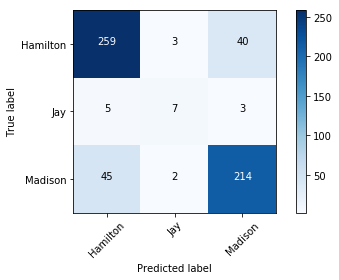

In [9]:
all_cv_predictions = cross_val_predict(estimator=lr, X=X_train_bow, y=y_train, cv=5)
print(len(all_cv_predictions), len(y_train))

cnf_matrix = confusion_matrix(y_train, all_cv_predictions)
plot_confusion_matrix(cnf_matrix, classes=['Hamilton','Jay','Madison'], normalize=False)
plt.show()

### Logistic Regression

0.7866462896148585


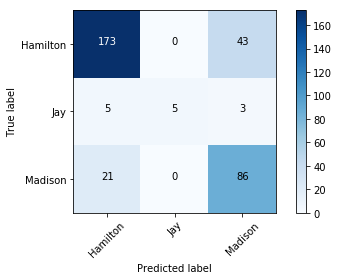

In [25]:
def model_train(X_train_bow, y_train):
    # model fitting
    model = LogisticRegression(
        solver='saga',
        multi_class='auto',
        class_weight='balanced',
        penalty='l2',
        C=0.135,
        max_iter=1000)
    model.fit(X_train_bow, y_train)
    return model

def evaluate_model(y_test, y_test_predicted):
    report = classification_report(y_test, y_test_predicted, digits=3, output_dict=True)
    weighted_f1 = report['weighted avg']['f1-score']
    return weighted_f1

lr_model = model_train(X_train_bow, y_train)
y_test_predicted = lr_model.predict(X_test_bow)
weighted_f1 = evaluate_model(y_test, y_test_predicted)
print(weighted_f1)

cnf_matrix = confusion_matrix(y_test, y_test_predicted)
plot_confusion_matrix(cnf_matrix, classes=['Hamilton','Jay','Madison'], normalize=False)
plt.show()

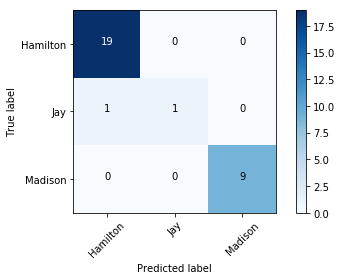

In [75]:
###
df_test_block_predictions = df_test_block_clean.copy()
df_test_block_predictions.insert(3, 'Prediction', y_test_predicted)

no_list = []
true_author_list = []
pred_author_list = []
mad_list = []
jay_list = []
ham_list = []

for i, group_df in df_test_block_predictions.groupby('No.'):
    
    true_author_counter = Counter(group_df['Author'])
    pred_author_counter = Counter(group_df['Prediction'])
    true_author = true_author_counter.most_common()[0][0]
    pred_author = pred_author_counter.most_common()[0][0]
    total = sum(pred_author_counter.values())
    
    mad_list.append(pred_author_counter['Madison']/total)
    jay_list.append(pred_author_counter['Jay']/total)
    ham_list.append(pred_author_counter['Hamilton']/total)
    no_list.append(i)
    true_author_list.append(true_author)
    pred_author_list.append(pred_author)

final_prediction_dict = {
    'No.':no_list,
    'True Author':true_author_list,
    'Predicted Author':pred_author_list,
    'Madison confidence':mad_list,
    'Jay confidence':jay_list,
    'Hamilton confidence':ham_list}

cnf_matrix = confusion_matrix(true_author_list, pred_author_list)
plot_confusion_matrix(cnf_matrix, classes=['Hamilton','Jay','Madison'], normalize=False)
plt.show()

In [76]:
df_doc_test_predictions = pd.DataFrame(final_prediction_dict)
df_doc_test_predictions

,No.,True Author,Predicted Author,Madison confidence,Jay confidence,Hamilton confidence
0,5,Jay,Jay,0.000000,0.800,0.200000
1,52,Madison,Madison,0.727273,0.000,0.272727
2,53,Madison,Madison,0.846154,0.000,0.153846
3,54,Madison,Madison,0.916667,0.000,0.083333
4,55,Madison,Madison,0.700000,0.000,0.300000
5,56,Madison,Madison,0.777778,0.000,0.222222
6,57,Madison,Madison,0.857143,0.000,0.142857
7,58,Madison,Madison,0.833333,0.000,0.166667
8,62,Madison,Madison,0.846154,0.000,0.153846
9,63,Madison,Madison,0.692308,0.000,0.307692


In [77]:
df_doc_test_predictions.to_csv("../processed_data/doc_test_predictions.csv", index=False)